In [1]:
import torch
import torch.nn as nn
import pre_process as prep
from data_list import ImageList
import numpy as np
from torchvision import transforms, models

import matplotlib.pyplot as plt

import model as model_no

from sklearn.svm import LinearSVC

from eval import AverageMeter

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)

from sklearn.linear_model import LinearRegression

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    # ResizeImage(resize_size),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  ])

In [3]:
def wrap_array(n_samples, n_bins):
    
    n_samples = np.array(n_samples)
    n_samples = n_samples.reshape(n_bins, len(n_samples)//n_bins).mean(1)
    return n_samples

## Load the source and target data

In [4]:
class Resnet50Fc(nn.Module):
    def __init__(self):
        super(Resnet50Fc, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.__in_features = model_resnet50.fc.in_features

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x
    
    def output_num(self):
        return self.__in_features

In [5]:
class predictor(nn.Module):
    def __init__(self, feature_len, cate_num):
        super(predictor, self).__init__()
        self.classifier = nn.Linear(feature_len, cate_num)
        self.classifier.weight.data.normal_(0, 0.01)
        self.classifier.bias.data.fill_(0.0)

    def forward(self, features):
        activations = self.classifier(features)
        return (activations)

    
class fine_net(nn.Module):
    def __init__(self, total_classes, batch_norm=False):
        super(fine_net, self).__init__()
        self.model_fc = model_no.Resnet50Fc()
        feature_len = self.model_fc.output_num()
        self.bottleneck_0 = nn.Linear(feature_len, 256)
        self.bottleneck_0.weight.data.normal_(0, 0.005)
        self.bottleneck_0.bias.data.fill_(0.1)
        if batch_norm:
            self.bottleneck_layer = nn.Sequential(self.bottleneck_0, nn.ReLU(), nn.BatchNorm1d(256))
        else:
            self.bottleneck_layer = nn.Sequential(self.bottleneck_0, nn.ReLU())
        self.classifier_layer = predictor(256, total_classes)

    def forward(self, x):
        features = self.model_fc(x)
        out_bottleneck = self.bottleneck_layer(features)
        logits = self.classifier_layer(out_bottleneck)
        return logits

In [6]:
def percls_accuracy(all_pred, all_label, num_class=0):
    """Computes per class accuracy"""
    num_class = len(set(all_label)) if num_class == 0 else num_class
    all_pred = np.asarray(all_pred)
    all_label = np.asarray(all_label)

    cls_acc = -np.ones([num_class])
    for i in range(num_class):
        idx = (all_label == i)
        if idx.sum() > 0:
            cls_acc[i] = (all_pred[idx] == all_label[idx]).mean() * 100.0

    return cls_acc

In [25]:
source, target = "sketch", "painting"

CBS = True
if CBS:
    model = fine_net(345, batch_norm=True)
    pretrained = torch.load("snapshot/domainNet_full_ablation/MemSAC_%s%s_QS_48000_BS_32_tau_0-07_lambda_0_CAS/best_model.pth.tar"%(source, target))
else:
    model = fine_net(345)
    pretrained = torch.load("snapshot/domainNet_full/CDAN/CDAN_%s%s_QS_48000_BS_32_tau_0-007_lambda_0/best_model.pth.tar"%(source, target))
    pretrained = {k.partition("module.")[-1]:v for k,v in pretrained.items()}
    
# 
model.load_state_dict(pretrained, strict=True)
# 
model = model.cuda()
model = model.eval()

In [26]:
dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/visDA/", open("./data/visDA_full/%s_test.txt"%(target)).readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_target = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)
nclasses=345

dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/visDA/", open("./data/visDA_full/%s_test.txt"%(source)).readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_source = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)
nclasses=345

# dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/OfficeHome/Dataset10072016/", open("./data/officeHome/Product.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
# dataset_loader_source = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)
# nclasses=65

# dataset_list = ImageList("/newfoundland/tarun/datasets/birds/", open("./data/cub200/cub200_2011.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
# dataset_loader_source = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)
# nclasses=200

In [27]:
accuracy = AverageMeter()
all_preds = []
all_labels = []
for idx , (image, labels) in enumerate(dataset_loader_target):
    print("{}/{}".format(idx+1, len(dataset_loader_target)), end="\r")
    image = image.cuda()
    labels = labels.cuda()
    with torch.no_grad():
        outputs = model(image)
        predictions = outputs.detach().argmax(1)
    correct = torch.sum((predictions == labels).float())
    accuracy.update(correct/len(outputs), len(outputs))
    all_preds.extend(predictions.cpu().numpy().tolist())
    all_labels.extend(labels.cpu().numpy().tolist())
print_str = "\nCorrect Predictions: {}/{}".format(int(accuracy.sum), accuracy.count)
print_str1 = '\ntest_acc:{:.4f}'.format(accuracy.avg)
print(print_str + print_str1)

342/342
Correct Predictions: 9335/21850
test_acc:0.4272


In [28]:
classwise_accuracy = percls_accuracy(all_preds, all_labels, 345)
classwise_accuracy = {i:ca for i,ca in enumerate(classwise_accuracy)}

In [29]:
all_labels_source = []
for idx, (image, labels) in enumerate(dataset_loader_source):
    print("{}/{}".format(idx+1, len(dataset_loader_source)), end="\r")
    all_labels_source.extend(labels.numpy().tolist())

In [30]:
n_samples_per_class_target = dict(zip(*np.unique(all_labels, return_counts=True)))
n_samples_per_class_source = dict(zip(*np.unique(all_labels_source, return_counts=True)))

## Plot wrt source

In [41]:
sorted_sample = sorted(n_samples_per_class_source.items(), key=lambda l : l[1], reverse=True)
keyset = [k[0] for k in sorted_sample]
n_samples = [k[1] for k in sorted_sample]
accuracy = [classwise_accuracy[k] for k in keyset]
n_samples = wrap_array(n_samples, n_bins=69)
accuracy = wrap_array(accuracy, n_bins=69)

reg = LinearRegression().fit(np.array(n_samples).reshape(-1,1), accuracy)
print(reg.score(np.array(n_samples).reshape(-1,1), accuracy))

0.20479712634150946


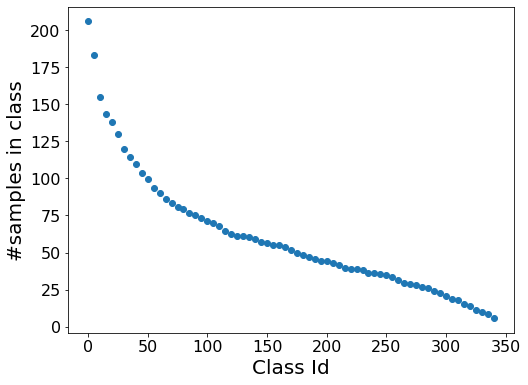

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(n_samples))*5, n_samples)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel("Class Id", fontsize=20)
plt.ylabel("#samples in class", fontsize=20)
plt.show()

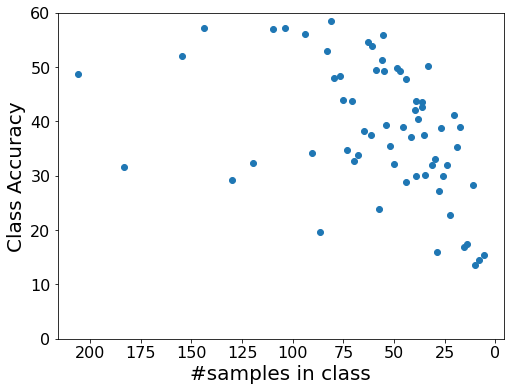

In [43]:
plt.figure(figsize=(8,6))

plt.scatter(n_samples, accuracy)
ax = plt.gca()
ax.invert_xaxis()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel("#samples in class", fontsize=20)
plt.ylabel("Class Accuracy", fontsize=20)

plt.ylim(0,60)

plt.show()

In [34]:
accuracy

array([48.63711495, 31.51515152, 52.03980237, 57.08752053, 67.4114276 ,
       29.15256241, 32.36162269, 62.03425746, 56.93852789, 57.22168788,
       62.02012214, 56.05194228, 34.1659919 , 19.72342376, 53.02422723,
       58.43245064, 48.00955454, 48.41020217, 43.95591719, 34.69919415,
       43.70037818, 32.79761905, 33.80392157, 38.28503437, 54.5462963 ,
       37.42659356, 53.92802663, 72.87494377, 49.50622363, 23.85113274,
       51.29442899, 55.97747932, 49.21548822, 39.35274424, 35.42032813,
       32.17616484, 49.73057195, 49.20148719, 38.97947214, 28.89665653,
       47.79069542, 61.90213777, 37.12678677, 42.09942667, 43.69254143,
       29.95332449, 40.5101626 , 42.58795148, 43.53618597, 37.56772575,
       30.0846738 , 50.20593368, 31.90741214, 33.15951893, 15.96137526,
       27.21464213, 38.69423132, 29.90240063, 32.06262333, 22.74397749,
       41.22235872, 35.19574494, 39.04785643, 16.96585918, 17.40908329,
       28.23153525, 13.64785106, 14.44795368, 15.50140195])

## Plot wrt target

In [35]:
sorted_sample = sorted(n_samples_per_class_target.items(), key=lambda l : l[1], reverse=True)
keyset = [k[0] for k in sorted_sample]
n_samples = [k[1] for k in sorted_sample]
accuracy = [classwise_accuracy[k] for k in keyset]
n_samples = wrap_array(n_samples, n_bins=43)
accuracy = wrap_array(accuracy, n_bins=43)

reg = LinearRegression().fit(np.array(n_samples).reshape(-1,1), accuracy)
print(reg.score(np.array(n_samples).reshape(-1,1), accuracy))

0.12182873453783083


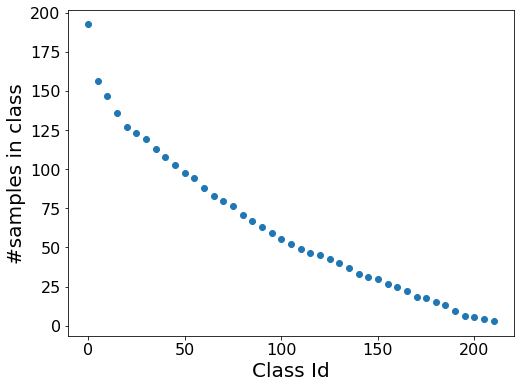

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(n_samples))*5, n_samples)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel("Class Id", fontsize=20)
plt.ylabel("#samples in class", fontsize=20)
plt.show()

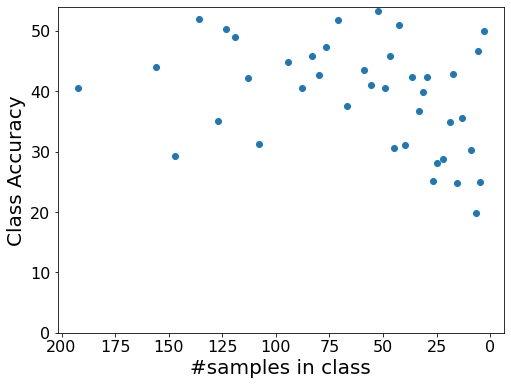

In [40]:
plt.figure(figsize=(8,6))

plt.scatter(n_samples, accuracy)
ax = plt.gca()
ax.invert_xaxis()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel("#samples in class", fontsize=20)
plt.ylabel("Class Accuracy", fontsize=20)

plt.ylim(0,54)
plt.show()